Courtesy to https://github.com/deric/clustering-benchmark

In [1]:
from scipy.io import arff
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests
import io
import urllib.request
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.preprocessing import StandardScaler
from datetime import date
import sys

from pycvi.cluster import generate_all_clusterings
from pycvi.scores import Inertia, GapStatistic, ScoreFunction, Hartigan, Diameter, CalinskiHarabasz, Silhouette, SCORES
from pycvi.compute_scores import compute_all_scores
import warnings
warnings.filterwarnings("ignore")

from utils import (
    get_data_labels, arff_from_github, load_data_from_github, URL_ROOT,
    PATH_UCR,
    write_list_datasets,
)

/home/natacha/.cache/pypoetry/virtualenvs/clusterexp-s4OGTNKW-py3.8/lib/python3.8/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [23]:

#DATA_SOURCE = "artificial"
DATA_SOURCE = "real-world"
PATH = f"{URL_ROOT}{DATA_SOURCE}/"
RES_DIR = f'./res/{DATA_SOURCE}/'

In [24]:
fname = f'{URL_ROOT}{DATA_SOURCE}.txt'

raw_text = requests.get(fname).text
all_datasets = raw_text.split("\n")
print(len(all_datasets))
all_datasets


24


['heart-statlog.arff',
 'water-treatment.arff',
 'balance-scale.arff',
 'thy.arff',
 'cpu.arff',
 'wdbc.arff',
 'zoo.arff',
 'arrhythmia.arff',
 'ecoli.arff',
 'glass.arff',
 'iris.arff',
 'dermatology.arff',
 'haberman.arff',
 'vehicle.arff',
 'vowel.arff',
 'sonar.arff',
 'wine.arff',
 'german.arff',
 'tae.arff',
 'letter.arff',
 'iono.arff',
 'wisc.arff',
 'segment.arff',
 'yeast.arff']

In [26]:
list_fname = f'.{RES_DIR}all_datasets-{DATA_SOURCE}.txt'
write_list_datasets(list_fname, all_datasets)

In [19]:
unimodal = [
    "birch-rg1.arff", "birch-rg2.arff",
    "golfball.arff",
]
unlabeled = [
    # Toy dataset
    "birch-rg3.arff",
    "mopsi-finland.arff", "mopsi-joensuu.arff",
    "s-set3.arff", "s-set3.arff",

    # Real-world
    "water-treatment.arff",
]


In [20]:
filenames = [
    fname for fname in all_datasets
    if (fname not in unimodal+unlabeled)]
print(len(filenames))
filenames

23


['heart-statlog.arff',
 'balance-scale.arff',
 'thy.arff',
 'cpu.arff',
 'wdbc.arff',
 'zoo.arff',
 'arrhythmia.arff',
 'ecoli.arff',
 'glass.arff',
 'iris.arff',
 'dermatology.arff',
 'haberman.arff',
 'vehicle.arff',
 'vowel.arff',
 'sonar.arff',
 'wine.arff',
 'german.arff',
 'tae.arff',
 'letter.arff',
 'iono.arff',
 'wisc.arff',
 'segment.arff',
 'yeast.arff']

In [6]:
# for f in filenames:
#     url = PATH + f
#     print(url)
#     data, meta = arff_from_github(url)
#     df = pd.DataFrame(data)
#     print(df.head())

,x,y,class
0,-1.98666,-0.002289,b'0'
1,-1.95108,0.032471,b'0'
2,-1.92679,-0.046936,b'0'
3,-1.86688,-0.067810,b'0'
4,-1.84698,0.008820,b'0'
...,...,...,...
2995,3.80911,3.881070,b'8'
2996,3.83362,4.140630,b'8'
2997,3.84756,3.910280,b'8'
2998,3.89923,3.946840,b'8'


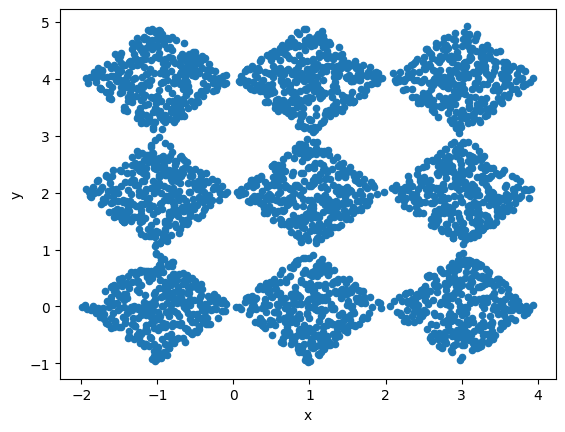

In [27]:
data, meta = arff_from_github(f'{URL_ROOT}artificial/diamond9.arff')
df = pd.DataFrame(data)
df.plot.scatter("x", "y")
df

In [33]:
df.dtypes
[t == "int" for t in df.dtypes]

[False, False, False]

In [8]:
def plot_clusters_old(data, clusterings, titles):
    fig, axes = plt.subplots(
        nrows=2, ncols=4, sharex=True, sharey=True, figsize=(15,10),
        tight_layout=True
    )
    for i, ax in enumerate(axes.flat[:len(clusterings)]):
        # Plot the clustering selected by a given score
        for i_label, cluster in enumerate(clusterings[i]):
            ax.scatter(data[cluster, 0], data[cluster, 1], s=0.5)
        ax.set_title(str(titles[i]))
    return fig, ax

def plot_clusters(data, clusterings, titles):
    # Some datasets are in 3D
    (N, d) = data.shape
    if d == 2:
        fig, axes = plt.subplots(
            nrows=2, ncols=4, sharex=True, sharey=True, figsize=(15,10),
            tight_layout=True
        )
    elif d == 3:
        fig = plt.figure(figsize=(15,10), tight_layout=True)
    # Plot the clustering selected by a given score
    for i in range(len(clusterings)):
        # Plot clusters one by one
        if d == 2:
            ax = axes.flat[i]
        elif d == 3:
            ax = fig.add_subplot(2, 4, i+1, projection='3d')
        for i_label, cluster in enumerate(clusterings[i]):
            if d == 2:
                ax.scatter(data[cluster, 0], data[cluster, 1], s=0.5)
            elif d == 3:
                ax.scatter(
                    data[cluster, 0], data[cluster, 1], data[cluster, 2], s=0.5
                )
        ax.set_title(str(titles[i]))
    return fig

In [9]:
df_bis = df.iloc[:, 0:-1]
df_bis

,x,y
0,-1.98666,-0.002289
1,-1.95108,0.032471
2,-1.92679,-0.046936
3,-1.86688,-0.067810
4,-1.84698,0.008820
...,...,...
2995,3.80911,3.881070
2996,3.83362,4.140630
2997,3.84756,3.910280
2998,3.89923,3.946840


In [10]:
X = df_bis.to_numpy()
X

array([[-1.98666e+00, -2.28882e-03],
       [-1.95108e+00,  3.24707e-02],
       [-1.92679e+00, -4.69360e-02],
       ...,
       [ 3.84756e+00,  3.91028e+00],
       [ 3.89923e+00,  3.94684e+00],
       [ 3.93759e+00,  4.01599e+00]])

In [11]:
n_clusters_range = [i for i in range(15)]

In [12]:
l_data = []
l_n_labels = []
l_fname = [
    # "diamond9.arff",
    "tetra.arff"
    # "xclara.arff",
    # "birch-rg1.arff",
    # "golfball.arff",
]
for fname in l_fname:
    if fname in unlabeled:
        with_labels = False
        n_labels = 1
    else:
        with_labels = True
    data, labels, meta = load_data_from_github(
        PATH + fname, with_labels=with_labels
    )
    if with_labels:
        n_labels = len(np.unique(labels))
    l_data.append(data)
    l_n_labels.append(n_labels)
    print(len(data), n_labels)


400 4


In [13]:
def experiment(X):
    N = len(X)

    clusterings = generate_all_clusterings(
            X,
            AgglomerativeClustering,
            n_clusters_range,
            DTW=False,
            scaler=StandardScaler(),
        )
    selected_clusterings = []

    for s in SCORES:
        score = s()
        print(" ================ {} ================ ".format(str(score)))
        if N > 10000 and s in [GapStatistic, Silhouette]:
            print("Dataset too big for {}".format(score))
        else:
            scores = compute_all_scores(
                score,
                X,
                clusterings,
                DTW=False,
                scaler=StandardScaler(),
            )

            for k in n_clusters_range:
                print(k, scores[0][k])

            selected_k = score.select(scores)[0]
            selected_clusterings.append(clusterings[0][selected_k])
            print("Selected k {}".format(selected_k))

    fig = plot_clusters(X, selected_clusterings, SCORES)
    fig.savefig("./tmp")


 ---------------- DATASET tetra.arff ---------------- 
 --------------------- True k: 4 --------------------- 
 ================ <pycvi.scores.Hartigan object at 0x7f08a3daac10> ================ 
0 190.5155221784184
1 135.00059036868402
2 201.88732969393956
3 397.7512087289112
4 24.601677135287698
5 25.886858086059803
6 27.636978416144082
7 28.49930703342196
8 28.97617281198704
9 22.404792339192767
10 23.33671186164341
11 24.25260596927206
12 25.802955145747397
13 22.22206072502881
14 0.0
Selected k 4
 ================ <pycvi.scores.CalinskiHarabasz object at 0x7f08a3183f10> ================ 
0 -628.9866502712858
1 0.0
2 135.0005903686839
3 202.51419634572176
4 402.51805720716976
5 326.03157815004556
6 282.4358526020469
7 255.88146686570346
8 238.74522161485922
9 227.43296903667306
10 215.71919429891065
11 207.60046333075456
12 202.2137377441845
13 199.36216929275813
14 195.82754212924024
Selected k 1
 ================ <pycvi.scores.GapStatistic object at 0x7f08a3daac10> ==============

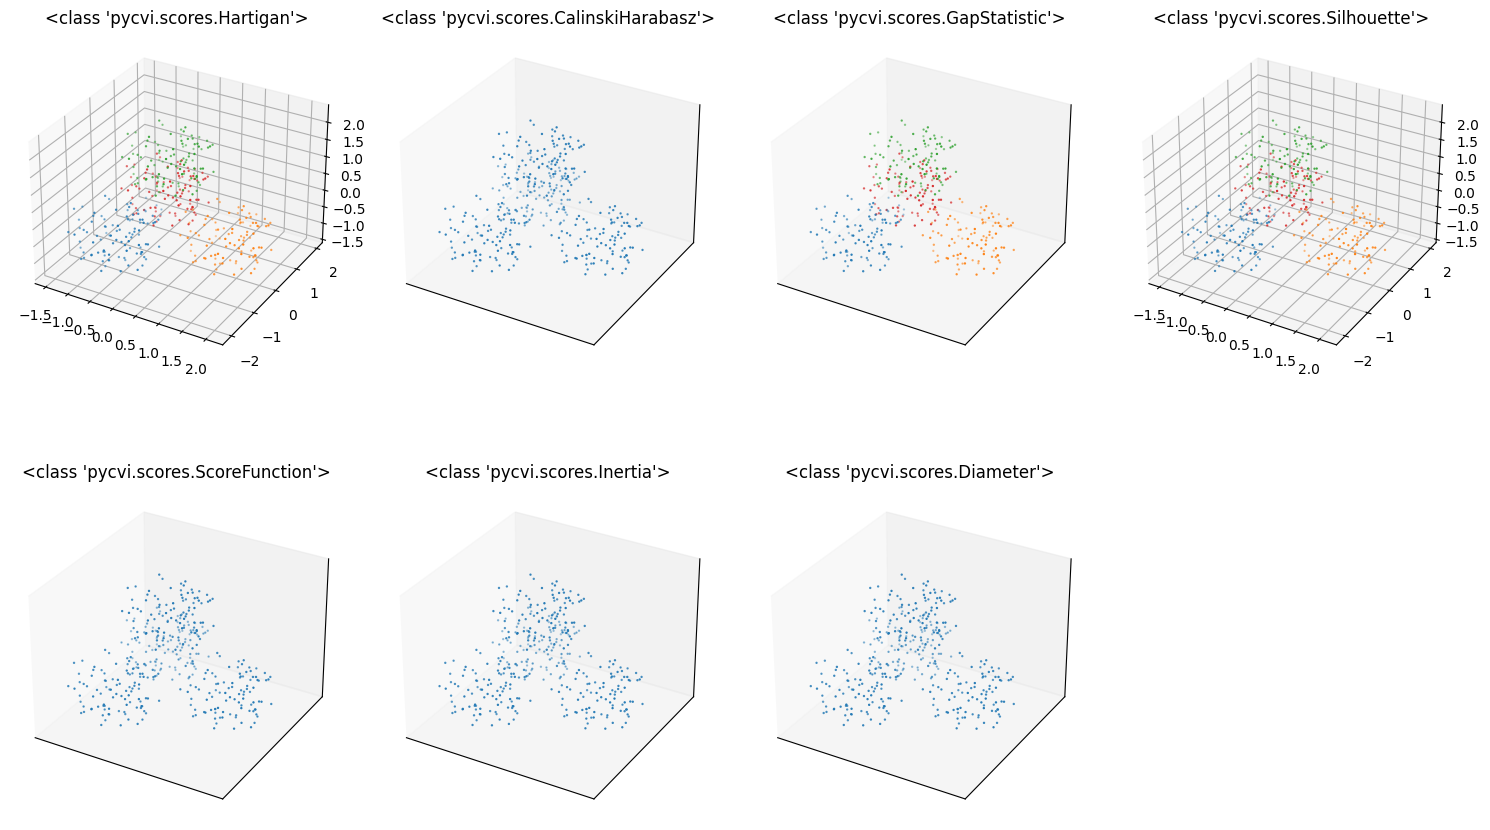

In [14]:
for i, X in enumerate(l_data):
    print(" ---------------- DATASET {} ---------------- ".format(l_fname[i]))
    print(" --------------------- True k: {} --------------------- ".format(l_n_labels[i]))
    experiment(X)